In [1]:
import scipy.io as sio
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
import timeit
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (10,15)
ds = sio.loadmat('face.mat')

In [2]:
X = ds['X']
l = ds['l'][0]
split = 0.8
W = 46
H = 56
X = pd.DataFrame(X.transpose())
N = X.shape[0]*split
l = pd.DataFrame(l)

In [3]:
X_train, X_test, l_train, l_test = train_test_split(X, l, test_size=(1-split))
# X_bar = np.mean(X, axis=1)
X_train, X_test = np.transpose(X_train.values), np.transpose(X_test.values)
l_train, l_test = np.transpose(l_train.values), np.transpose(l_test.values)
X_bar = np.transpose([np.mean(X_train, axis=1)])

In [4]:
A = np.subtract(X_train,X_bar)
# print(A.shape)
# print(np.transpose(X_train)[0]/255)
mean_img = np.transpose(np.array_split(np.concatenate(X_bar,axis=0)/255, W))
person = np.transpose(np.array_split(np.transpose(X_train)[0]/255, W))
# print(person)
# imgplot = plt.imshow(mean_img, cmap='gray')
# plt.imsave('images/original_person.png', person, cmap='gray')

(2576, 416)


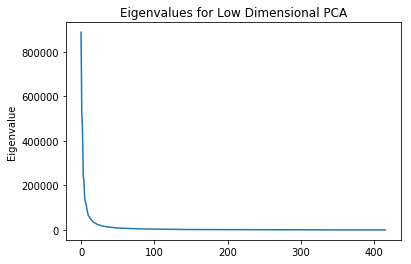

In [5]:
print(A.shape)
S_LDA = (1/N)*np.matmul(np.transpose(A),A)
w_lda, v_lda = np.linalg.eig(S_LDA)
inds = w_lda.argsort()[::-1]
w_lda = w_lda[inds]
v_lda = v_lda[:,inds]
plt.plot(w_lda)
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues for Low Dimensional PCA')
plt.show()

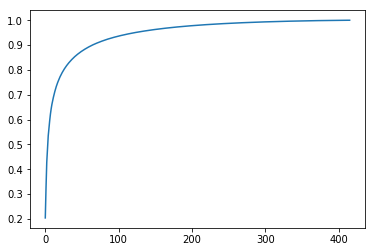

In [6]:
cum_w = np.cumsum(w_lda)/np.sum(w_lda)
plt.plot(cum_w)
plt.show()

In [7]:
M = np.argmax(cum_w>0.95)
V = v_lda[:,:M]
U = preprocessing.normalize(np.matmul(A,V), axis=0)
omega = np.matmul(np.transpose(A),U)
print(M)

122


In [8]:
A_test = np.transpose(np.subtract(X_test,X_bar))
omega_test = np.matmul(A_test, U)
incorrect = 0
wrong = []
right = []
for i in range(len(l_test[0])):
    omega_diff = np.subtract(omega,omega_test[i])
    train_index = np.argmin(np.diag(np.matmul(omega_diff,np.transpose(omega_diff))))
    if l_train[0][train_index] != l_test[0][i]:
        wrong.append([[l_test[0][i], i], [l_train[0][train_index], train_index]])
    else:
        right.append([[l_test[0][i], i], [l_train[0][train_index], train_index]])

In [9]:
print("Correct = " + str(round((1-len(wrong)/len(l_test[0]))*100,2)) + '%')

Correct = 58.65%


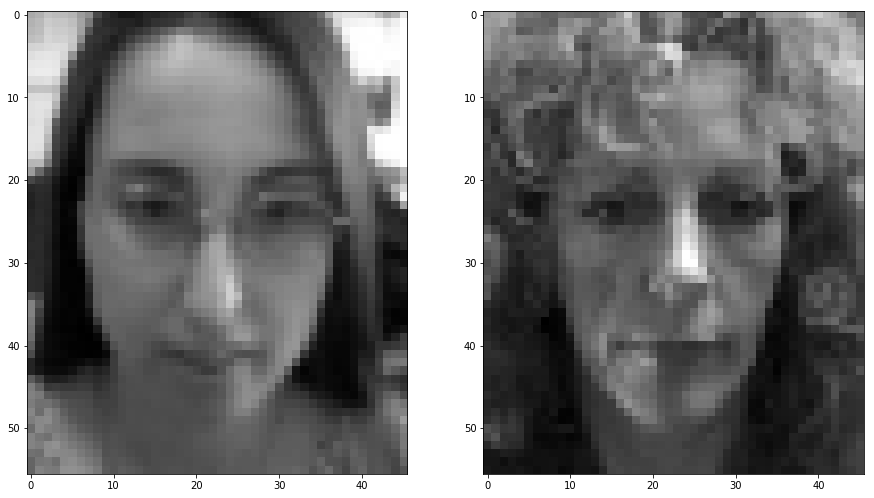

In [10]:
plt.figure(figsize=(15.0,9.0))
incorrect = wrong[5]
test_img = np.transpose(np.array_split(np.transpose(X_test)[incorrect[0][1]]/255, W))
train_img = np.transpose(np.array_split(np.transpose(X_train)[incorrect[1][1]]/255, W))
ax = plt.subplot(1, 2, 1)
ax.imshow(test_img, cmap='gray')
ax = plt.subplot(1, 2, 2)
ax.imshow(train_img, cmap='gray')

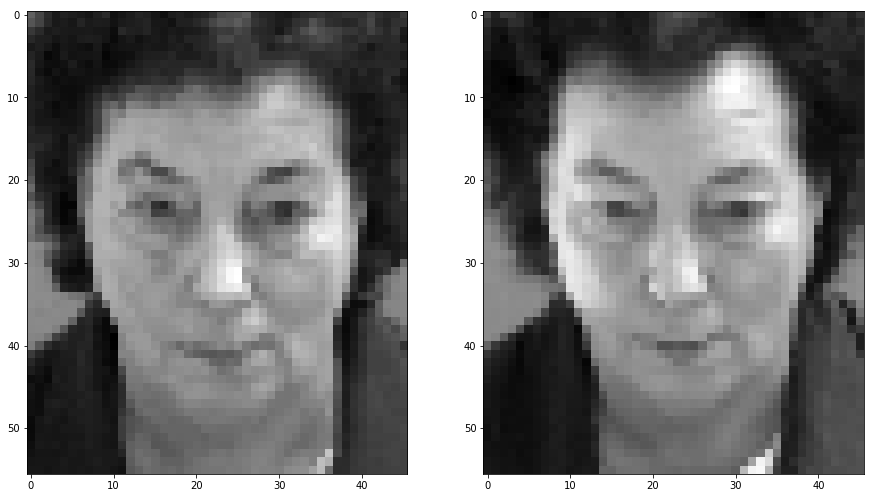

In [11]:
plt.figure(figsize=(15.0,9.0))
correct = right[0]
test_img = np.transpose(np.array_split(np.transpose(X_test)[correct[0][1]]/255, W))
train_img = np.transpose(np.array_split(np.transpose(X_train)[correct[1][1]]/255, W))
ax = plt.subplot(1, 2, 1)
ax.imshow(test_img, cmap='gray')
ax = plt.subplot(1, 2, 2)
ax.imshow(train_img, cmap='gray')